In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import random
import os

SEED = 42
random.seed(SEED)           # Seed for Python's random module
np.random.seed(SEED)        # Seed for NumPy
tf.random.set_seed(SEED)    # Seed for TensorFlow

# Ensure TensorFlow operations are deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Load and preprocess the data
data = pd.read_csv("model_data.csv")
data = data.drop(columns=['Unnamed: 0'])
X = data.drop(columns=['target_cost'])
y = data['target_cost']

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data into training, validation, test sets
# 80%:10%:10% ~roughly
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=(12/57), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [46]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/',histogram_freq=1)
# Define the model
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                               activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid', 'elu', 'swish'])))
        
    model.add(layers.Dense(1))
    
    rates = [0.01, 0.001, 0.0001]

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', rates)),
                  loss='mse',
                  metrics=['mae'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=100,
    executions_per_trial=2,
    directory='model_dir',
    project_name='target_cost_tuning'
)

# Search for the best model
tuner.search(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



# Train the best model on the full training data
history = best_model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]), epochs=350, batch_size=32, validation_data=(X_val, y_val), callbacks=tb_callback)

# Save the model
best_model.save("best_model.keras")


Reloading Tuner from model_dir\target_cost_tuning\tuner0.json
Epoch 1/350
2/2 [==============================] - 1s 196ms/step - loss: 0.0243 - mae: 0.1212 - val_loss: 0.0172 - val_mae: 0.1122
Epoch 2/350
2/2 [==============================] - 0s 69ms/step - loss: 0.0356 - mae: 0.1163 - val_loss: 0.0411 - val_mae: 0.1746
Epoch 3/350
2/2 [==============================] - 0s 71ms/step - loss: 0.0375 - mae: 0.1308 - val_loss: 0.0195 - val_mae: 0.1308
Epoch 4/350
2/2 [==============================] - 0s 69ms/step - loss: 0.0291 - mae: 0.1212 - val_loss: 0.0560 - val_mae: 0.1594
Epoch 5/350
2/2 [==============================] - 0s 69ms/step - loss: 0.0265 - mae: 0.0893 - val_loss: 0.0511 - val_mae: 0.1492
Epoch 6/350
2/2 [==============================] - 0s 69ms/step - loss: 0.0233 - mae: 0.1007 - val_loss: 0.0889 - val_mae: 0.2472
Epoch 7/350
2/2 [==============================] - 0s 69ms/step - loss: 0.0326 - mae: 0.1243 - val_loss: 0.0673 - val_mae: 0.2006
Epoch 8/350
2/2 [==========

In [47]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 192)               12480     
                                                                 
 dense_3 (Dense)             (None, 192)               37056     
                                                                 
 dense_4 (Dense)             (None, 96)                18528     
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 73665 (287.75 KB)
Trainable params: 73665 

In [48]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Input layer details
input_shape = best_model.layers[0].input_shape
print(f"Input layer shape: {input_shape[1]}")

# Details of hidden layers
print(f"The optimal number of layers is {best_hps.get('num_layers')}.")
for i in range(best_hps.get('num_layers')):
    print(f"The optimal number of units in layer {i+1} is {best_hps.get('units_' + str(i))}.")

# Output layer details
output_shape = best_model.layers[-1].output_shape
print(f"Output layer shape: {output_shape[1]}")

print(f"The optimal learning rate is {best_hps.get('learning_rate')}.")

# Try 128 layer 1

Input layer shape: 20
The optimal number of layers is 5.
The optimal number of units in layer 1 is 64.
The optimal number of units in layer 2 is 64.
The optimal number of units in layer 3 is 192.
The optimal number of units in layer 4 is 192.
The optimal number of units in layer 5 is 96.
Output layer shape: 1
The optimal learning rate is 0.01.


In [49]:
best_hps.get('units_4')

96

1/1 [==============================] - 0s 45ms/step


Test MAE: 1.3654839690877714
Test MSE: 3.760864027473321
Test RMSE: 1.9392947242421201
Test R^2: -3.2157546001594977
Test MAPE: 7.461500622441926


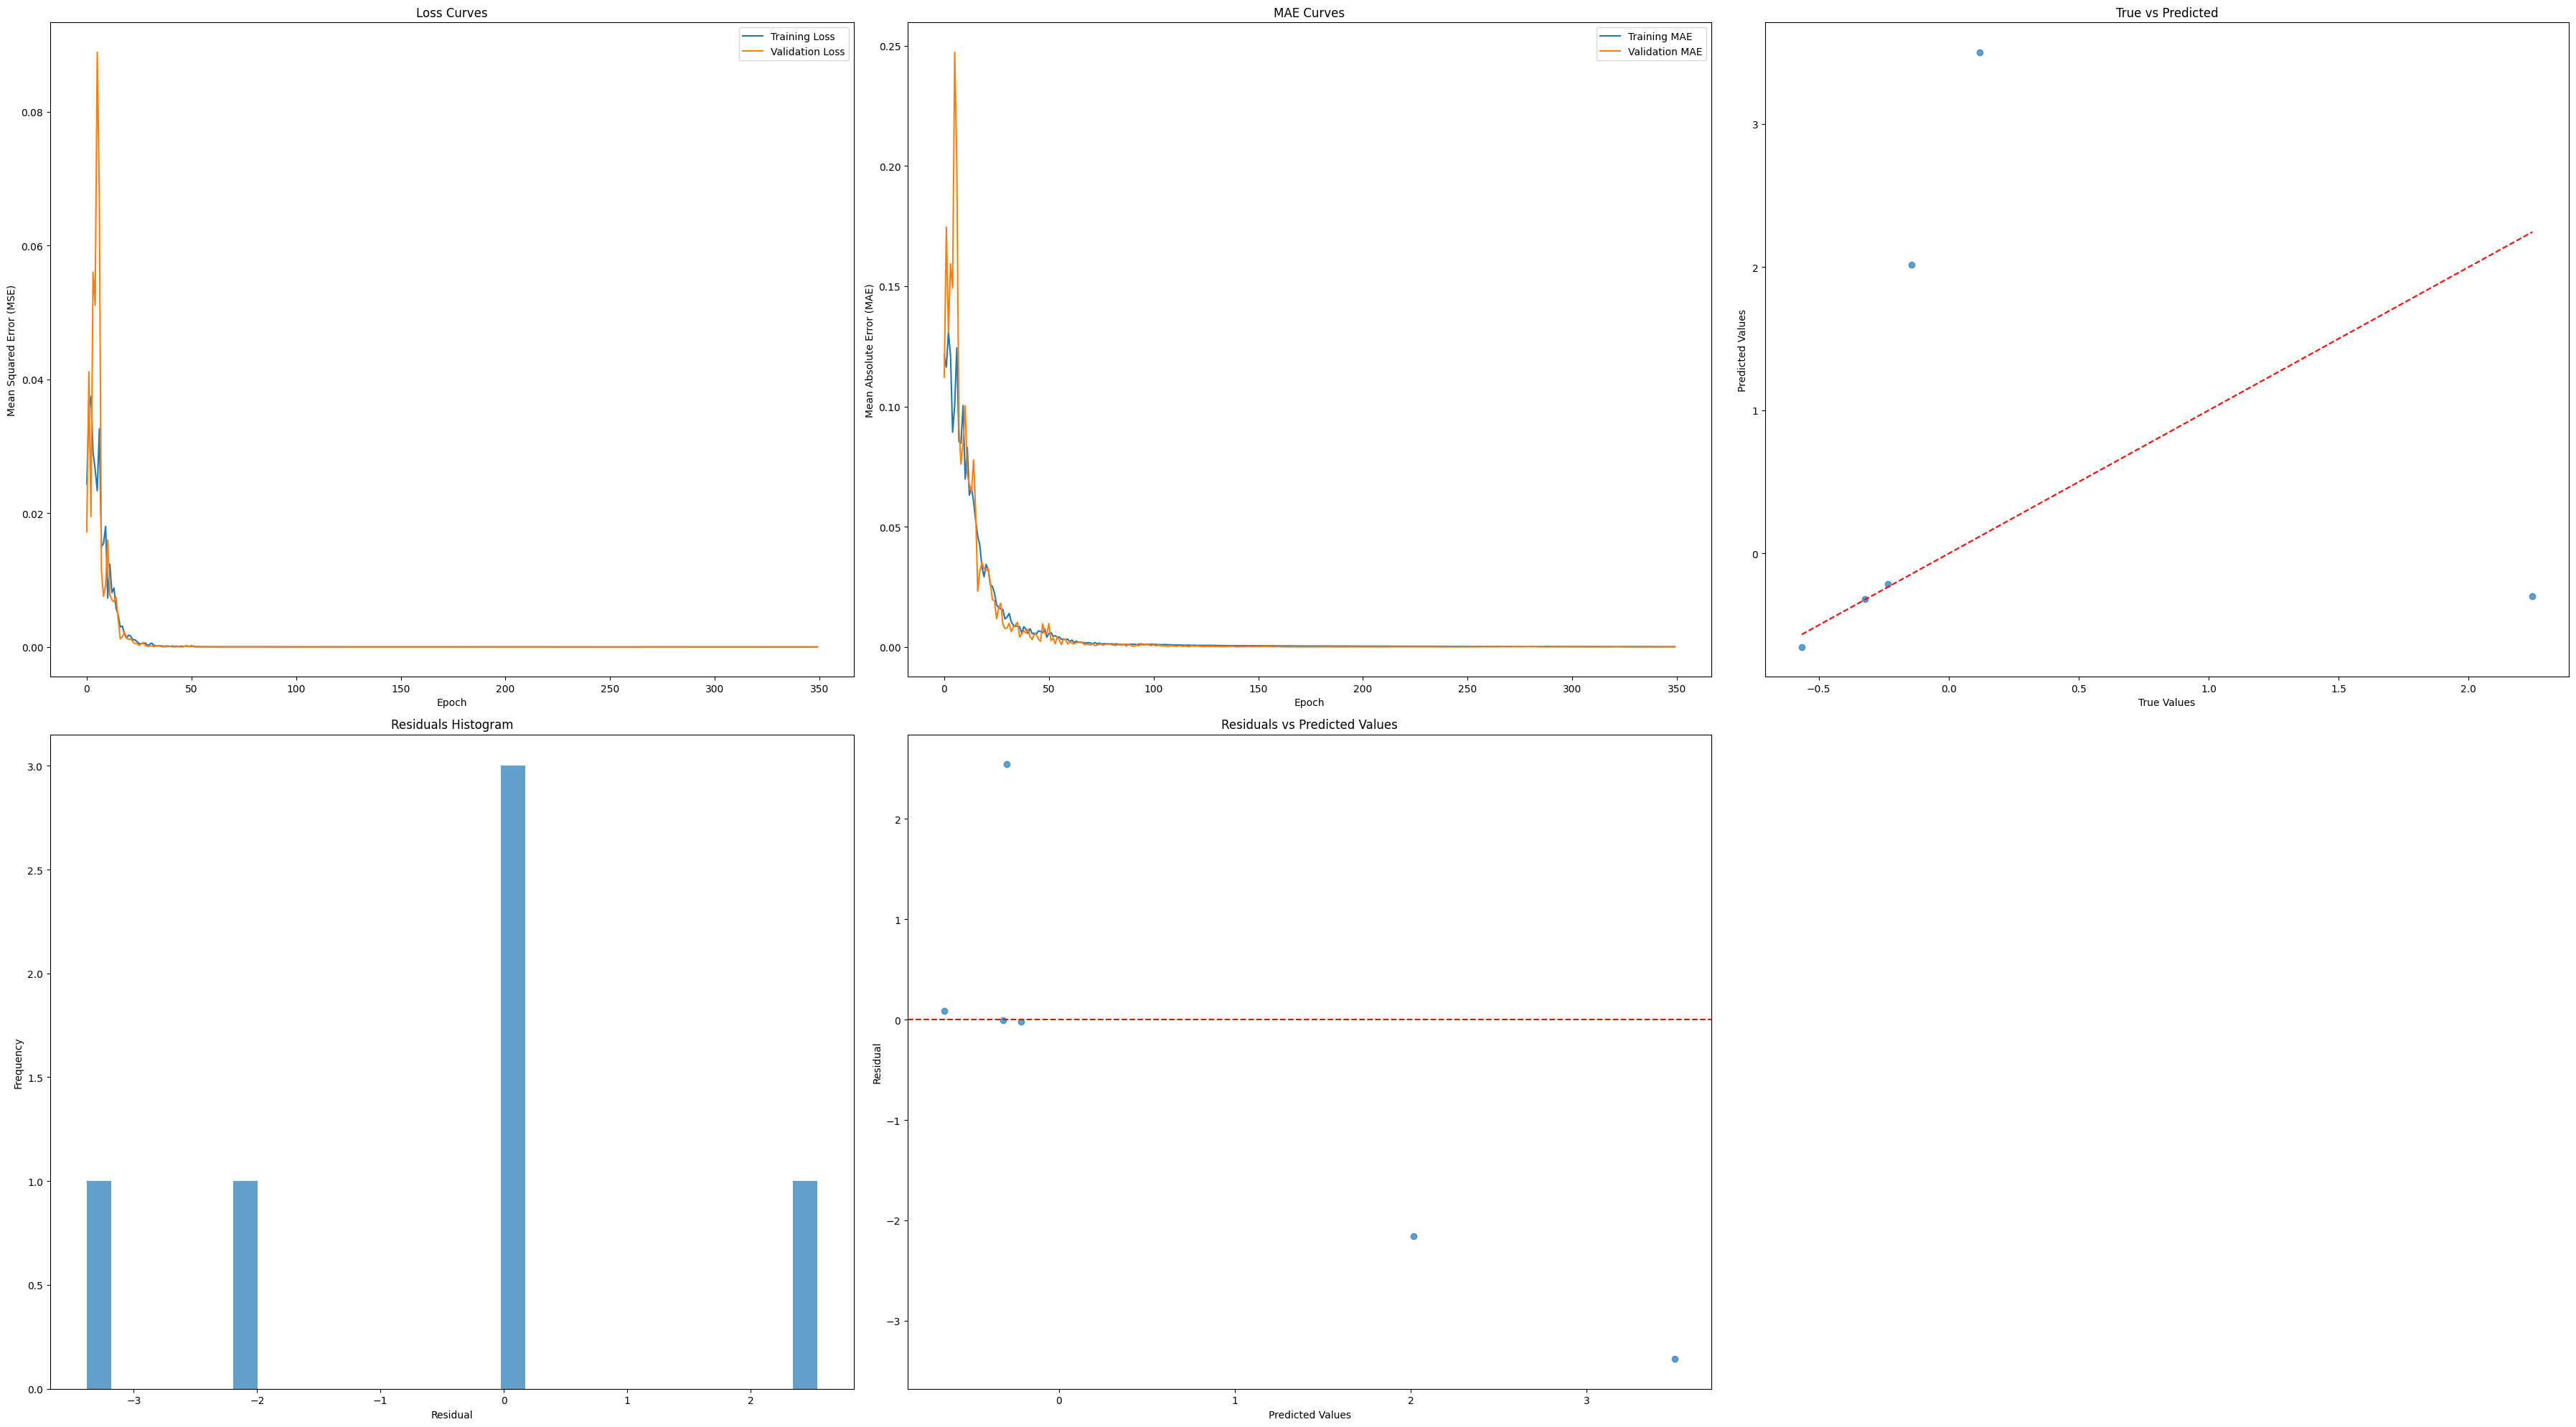

In [50]:

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
residuals = y_test - y_pred.squeeze()

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r2)
print("Test MAPE:", mape)

# Plotting
plt.figure(figsize=(36, 20))

# Loss Curves
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# MAE Curves
plt.subplot(2, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

# True vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')

# Residuals Histogram
plt.subplot(2, 3, 4)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')

# Residuals Plot
plt.subplot(2, 3, 5)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()


In [51]:
# Predictions
y_preds = best_model.predict(X_test)

y_preds


1/1 [==============================] - 0s 16ms/step


array([[-0.65287113],
       [-0.29722196],
       [-0.31873763],
       [ 3.500306  ],
       [-0.21561414],
       [ 2.016386  ]], dtype=float32)

In [52]:
y_test

47   -0.565764
12    2.244818
0    -0.323041
45    0.119366
55   -0.234381
30   -0.143361
Name: target_cost, dtype: float64